# 🌍 Easy Wikipedia Scraping - Demographics of United Nations Countries

In this notebook, I will show you how to easily get information online using **scraping**. For this, our objective will be to collect **demographic information** concerning the 193 member countries of the United Nations. Scraping often requires data cleaning as a second step. We will also tackle this task. It is possible to reuse these techniques to create your own dataset.

Here is the Wikipedia page that we are going to scrap: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

**Let's start!** 😉

# Imports

We need these imports:
- **requests** for http requests
- **BeautifulSoup** for the scraping
- **pandas** to gather the data in a dataframe
- **matplotlib** for data analysis

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# Scraping

For this step I really recommend inspecting the source code of the website to spot the html tags surrounding the data we want. It will be easier for you to follow. To summarize, we will be interested in the following tags:
- **table**: the whole central table with the countries
- **tr**: the rows in the table including the header
- **th**: the first cells of the rows (rank position)
- **td**: the cells in general (several per row)
- **a**: a hyperlink

To proceed, we will scrape the data by storing it in lists and then gathering them in a dataframe. We do not deal with the format for the moment. What matters is the information. We will clean the data later.


In [2]:
# Create the empty lists for the information we want
ranks, countries, links, continents, populations, percentages, dates = [[] for i in range(7)]

# Retrieve the response to the request from the url
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
response = requests.get(url)

# Response 200 = everything went well
if response.ok:
    
    # Extract the table and the rows, except the two first
    soup = BeautifulSoup(response.text, 'lxml')
    table_rows = soup.find('table').findAll('tr')[2:]
    
    # Loop over each row and append the information in our lists
    for row in table_rows:
        
        # Rank
        rank = row.find('th').text
        ranks.append(rank)
        
        # Cells of each row (after Rank)
        cells = row.findAll('td')
        
        # Countries + Links
        country = cells[0].find('a').text
        countries.append(country)
        link = 'https://en.wikipedia.org' + cells[0].find('a')['href']
        links.append(link)
        
        # Continent
        continent = cells[1].text
        continents.append(continent)
        
        # Population
        population = cells[2].text
        populations.append(population)
        
        # Percentage of the world
        percentage = cells[3].text
        percentages.append(percentage)
        
        # Dates
        date = cells[4].text
        dates.append(date)

Now the lists are full of collected information, we can zip them and create the associated raw dataframe *data0*. We rename the columns in our own way.

In [3]:
data0 = pd.DataFrame(list(zip(ranks, countries, continents, populations, percentages, dates, links)),
                    columns=['Rank', 'Country', 'Continent', 'Population', 'Percentage', 'Date', 'Links'])
data0

,Rank,Country,Continent,Population,Percentage,Date,Links
0,1\n,China,Asia,"1,412,600,000",17.7%\n,31 Dec 2021,https://en.wikipedia.org/wiki/Demographics_of_...
1,2\n,India,Asia,"1,375,586,000",17.2%\n,1 Mar 2022\n,https://en.wikipedia.org/wiki/Demographics_of_...
2,3\n,United States,North America,"333,100,150",4.18%,15 Sep 2022\n,https://en.wikipedia.org/wiki/Demographics_of_...
3,4\n,Indonesia,Asia[b],"275,773,800",3.46%\n,1 Jul 2022,https://en.wikipedia.org/wiki/Demographics_of_...
4,5\n,Pakistan,Asia,"229,489,000",2.88%\n,1 Jul 2022,https://en.wikipedia.org/wiki/Demographics_of_...
...,...,...,...,...,...,...,...
236,–\n,Niue,Oceania,"1,549",0%\n,1 Jul 2021,https://en.wikipedia.org/wiki/Demographics_of_...
237,–\n,Tokelau,Oceania,"1,501",0%\n,1 Jul 2021,https://en.wikipedia.org/wiki/Demographics_of_...
238,195\n,Vatican City,Europe,825,0%\n,1 Feb 2019,https://en.wikipedia.org/wiki/Demographics_of_...
239,–\n,Cocos (Keeling) Islands,Oceania,573,0%\n,30 Jun 2020,https://en.wikipedia.org/wiki/Demographics_of_...


Voilà, the information are structures. But it seems that the format is not clean. This is due to unnecessary line breaks *'\n'* or reference indices *'\[i\]'*. It is not a big task to correct these problems. We will do it in the next part.

# Cleaning

As said previously, we will correct the format and remove the elements that could interfere with the use of the data. For example, we don't want the '%' symbol or the commas in the population column. We should remove the unranked countries as well since they are not part of the official UN list (193 members + 2 observe states). It is of course an arbitrary choice and you can choose to keep them. Finally, we convert the data types to *integer*, *float* or *datetime* where it is consistant.

**Let's create the cleaning function.**

In [4]:
def cleaning(df):
    df = df.copy()
    
    # Remove '\n' and '[i]' and '%' characters everywhere
    df = df.replace(r'(\n)|(\[\w\])|(%)', '', regex=True)
    
    # Remove commas in the Population column
    df['Population'] = df['Population'].replace(r',', '', regex=True)
    
    # Drop unranked
    df = df[df['Rank'] != '–']
    
    # Change dtypes to int
    df = df.astype({'Population': 'int', 'Rank': 'int', 'Percentage': 'float'})
    
    # Datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

In [5]:
data = cleaning(data0)
data

,Rank,Country,Continent,Population,Percentage,Date,Links
0,1,China,Asia,1412600000,17.700000,2021-12-31,https://en.wikipedia.org/wiki/Demographics_of_...
1,2,India,Asia,1375586000,17.200000,2022-03-01,https://en.wikipedia.org/wiki/Demographics_of_...
2,3,United States,North America,333100150,4.180000,2022-09-15,https://en.wikipedia.org/wiki/Demographics_of_...
3,4,Indonesia,Asia,275773800,3.460000,2022-07-01,https://en.wikipedia.org/wiki/Demographics_of_...
4,5,Pakistan,Asia,229489000,2.880000,2022-07-01,https://en.wikipedia.org/wiki/Demographics_of_...
...,...,...,...,...,...,...,...
219,191,San Marino,Europe,33705,0.000422,2022-03-30,https://en.wikipedia.org/wiki/Demographics_of_...
223,192,Palau,Oceania,17957,0.000225,2021-07-01,https://en.wikipedia.org/wiki/Demographics_of_...
226,193,Nauru,Oceania,11832,0.000148,2021-07-01,https://en.wikipedia.org/wiki/Demographics_of_...
228,194,Tuvalu,Oceania,10679,0.000134,2021-07-01,https://en.wikipedia.org/wiki/Demographics_of_...


**Perfect!** We created a clean dataset of the United Nations countries by ourselves! We are now able to use them to create some nice charts. Let's do it for fun. 😄

# Data Analysis

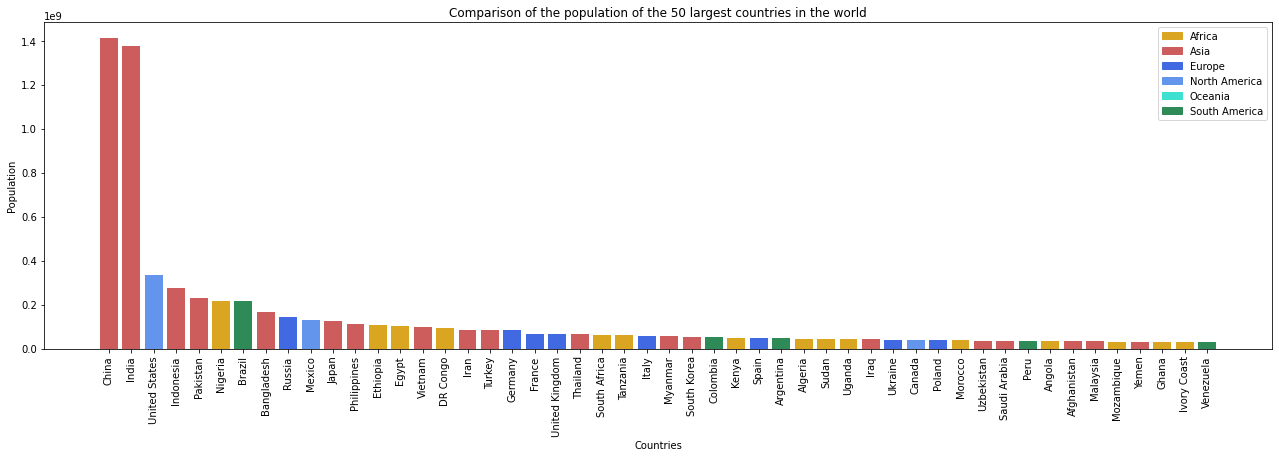

In [6]:
colors = {'Africa': 'goldenrod', 'Asia': 'indianred', 'Europe': 'royalblue',
          'North America': 'cornflowerblue', 'Oceania': 'turquoise', 'South America': 'seagreen'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.figure(figsize=(22, 6))

n_display = 50
c = data['Continent'].map(colors)
plt.bar(data['Country'][:n_display], data['Population'][:n_display], color=c)
plt.title(f"Comparison of the population of the {n_display} largest countries in the world")
plt.xlabel("Countries")
plt.ylabel("Population")
plt.xticks(rotation='vertical')
plt.legend(handles, labels)

plt.show()

And the outliers are... **China and India!**

**Note:** This representation should be taken with caution since we have in our dataset population values recorded between 2017 and 2022 (when I write). However if we look at the largest countries, the values are around 2021 and 2022 which are close periods of time.

In [7]:
print("Oldest date:", data['Date'].min())
print("Most recent date:", data['Date'].max())

Oldest date: 2017-12-15 00:00:00
Most recent date: 2022-09-15 00:00:00


To finish, we can see the distribution of the population between the different continents.

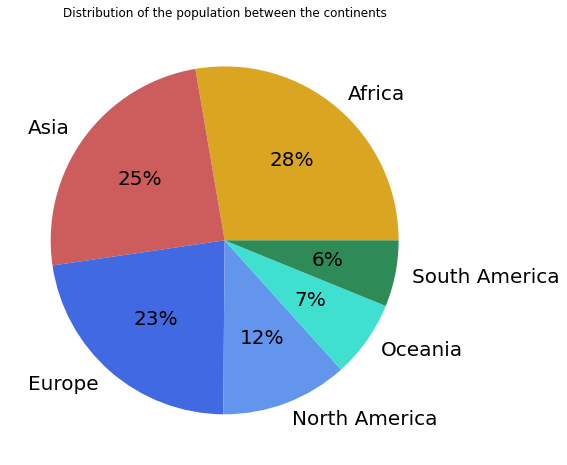

In [8]:
plt.figure(figsize=(8, 8))

labels = data['Continent'].value_counts().index
plt.pie(data['Continent'].value_counts(), labels=labels, colors=colors.values(), autopct='%1.0f%%', textprops={'fontsize': 20})
plt.title("Distribution of the population between the continents")

plt.show()

Thank you for reading until the end. I hope you liked this little exercise. If you have any suggestion, please leave me a comment!

**Have a nice day.** 😊